# Analysis: Different logarithm of Gamma function implementations

Notebook to find out if we can replace `gammaln` of scipy with a numba implementation

In [2]:
from jupyter_black import load

load(line_length=100)

In [331]:
from scipy.special import gammaln, gamma
from numba import njit, float64
from timeit import timeit
import numpy as np

## Naïve method

Gets slower for larger $x$. Only works with integers

In [5]:
@njit()
def gammaln_pos_int(x: float64):
    """Logarithm of the Gamma function for positive integer values (as float64)."""
    result = 1.0
    while x - 2.0 > 1e-6:
        x -= 1.0
        result *= x
    return np.log(result)

In [6]:
%%time
gammaln_pos_int(5)

CPU times: user 118 ms, sys: 6.84 ms, total: 124 ms
Wall time: 124 ms


3.1780538303479458

In [7]:
%%time
gammaln_pos_int(5)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


3.1780538303479458

In [8]:
%%timeit -r 100 -n 10000
gammaln_pos_int(25)

139 ns ± 34.4 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [9]:
%%timeit -r 100 -n 10000
gammaln(25)

672 ns ± 67.6 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [45]:
%%timeit -r 100 -n 10000
gammaln_pos_int(1000)

934 ns ± 90.6 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [46]:
%%timeit -r 100 -n 10000
gammaln(1000)

664 ns ± 44.6 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [10]:
abs(gammaln_pos_int(25) - gammaln(25))

0.0

In [451]:
abs(gammaln_pos_int(150) - gammaln(150))

0.0

## Sterling method 

In [267]:
@njit()
def gammaln_pos_float(x: float64):
    """Logarithm of the Gamma function for positive integer values (as float64)."""

    f = np.log(np.sqrt(2 * np.pi))

    return f + np.log(x) * (x - 0.5) - x

In [268]:
%time
gammaln_pos_float(125)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


477.0439988273413

In [269]:
%%timeit -r 100 -n 10000
gammaln_pos_float(125)

130 ns ± 34.9 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [270]:
%%timeit -r 100 -n 10000
gammaln(125)

668 ns ± 67.5 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [389]:
for x in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 5.0, 7.5, 10, 15, 20, 30]:
    print(
        x,
        abs(gammaln_pos_float(x) - gammaln(x)),
        abs(np.exp(gammaln_pos_float(x)) - np.exp(gammaln(x))),
        abs(gamma(x) - np.exp(gammaln(x))),
    )

0.1 0.5127400813319152 3.8163205496915644 0.0
0.2 0.3222939154958817 1.264845287976411 0.0
0.5 0.1534264097200273 0.2521069498392352 0.0
1.0 0.08106146679532733 0.07786299110421091 0.0
1.5 0.054814121051917686 0.047270372926261794 0.0
2.0 0.04134069595540946 0.04049782425550863 0.0
5.0 0.016644691189821703 0.3961664084819958 3.552713678800501e-15
7.5 0.01110455975820912 20.664507784007355 1.1368683772161603e-12
10 0.008330563433359472 3010.43812589522 1.7462298274040222e-10
15 0.0055547335519641194 482909720.0357361 0.0001678466796875
20 0.004166319691996989 505758070775344.0 80.0
30 0.002777674929745899 2.452546297416522e+28 7.430939385161318e+16


## Itegration by parts method

From [wikipedia](https://en.wikipedia.org/wiki/Gamma_function#Approximations)

In [498]:
@njit()
def gammaln_pos_float_2(z: float64):
    """Logarithm of the Gamma function for positive integer values (as float64)."""

    x = 12.0
    result = 0.0
    for n in range(30):
        denominator = 1.0
        for i in range(n + 1):
            denominator *= z + i
        result += x**n / denominator
    return np.log(x**z * np.exp(-x) * result)

In [500]:
%%timeit -r 100 -n 10000
gammaln_pos_float_2(1.5)

438 ns ± 3.49 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [501]:
%%timeit -r 100 -n 10000
gammaln(1.5)

471 ns ± 3.8 ns per loop (mean ± std. dev. of 100 runs, 10,000 loops each)


In [492]:
for x in [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]:
    print(
        x,
        abs(gammaln_pos_float_2(x) - gammaln(x)),
        abs(np.exp(gammaln_pos_float_2(x)) - np.exp(gammaln(x))),
        abs(np.exp(gammaln_pos_float_2(x)) - gamma(x)),
    )

1.0 3.2930392500035596e-06 3.2930338279557603e-06 3.2930338279557603e-06
1.1 3.152121549186704e-06 2.9987685362664607e-06 2.9987685364885053e-06
1.2 3.070431918480998e-06 2.8191702852176093e-06 2.8191702853286316e-06
1.3 3.0559713881106454e-06 2.74264057886775e-06 2.74264057886775e-06
1.4 3.11899672159055e-06 2.7673686222584593e-06 2.7673686222584593e-06
1.5 3.2723819318042358e-06 2.9000682332247507e-06 2.9000682332247507e-06
1.6 3.53203142296199e-06 3.1559187171348313e-06 3.1559187172458536e-06
1.7 3.917349525595082e-06 3.55944853724921e-06 3.5594485374712548e-06
1.8 4.451771390676096e-06 4.146298396179304e-06 4.146298396068282e-06
1.9 5.1633603647890935e-06 4.9659307562732735e-06 4.965930756162251e-06
2.0 6.085477079432475e-06 6.085458562954393e-06 6.085458562954393e-06


In [477]:
for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(
        x,
        abs(gammaln_pos_float_2(x) - gammaln(x)),
        abs(np.exp(gammaln_pos_float_2(x)) - np.exp(gammaln(x))),
        abs(np.exp(gammaln_pos_float_2(x)) - gamma(x)),
    )

0.1 2.6605757597053525e-09 2.5311408080597175e-08 2.5311408080597175e-08
0.2 7.2701593634150186e-09 3.337616583110048e-08 3.337616583110048e-08
0.3 1.4714190976761188e-08 4.4018516831556553e-08 4.4018516831556553e-08
0.4 2.6174011846791245e-08 5.805813341197563e-08 5.805813341197563e-08
0.5 4.3205121480482944e-08 7.657908240865652e-08 7.657908240865652e-08
0.6 6.783020634060222e-08 1.010122141487102e-07 1.010122141487102e-07
0.7 1.0265027283740125e-07 1.3324572711859162e-07 1.3324572756268083e-07
0.8 1.5097650027384724e-07 1.7577131439239224e-07 1.7577131417034764e-07
0.9 2.1698572108541647e-07 2.3187714437433726e-07 2.3187714415229266e-07


In [478]:
for x in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 5.0, 7.5, 10, 15, 20, 30]:
    print(
        x,
        abs(gammaln_pos_float_2(x) - gammaln(x)),
        abs(np.exp(gammaln_pos_float_2(x)) - np.exp(gammaln(x))),
        abs(np.exp(gammaln_pos_float_2(x)) - gammaln(x)),
    )

0.1 2.6605757597053525e-09 2.5311408080597175e-08 7.260795021623118
0.2 7.2701593634150186e-09 3.337616583110048e-08 3.066779856191853
0.5 4.3205121480482944e-08 7.657908240865652e-08 1.2000888314017335
1.0 3.059026321617574e-07 3.0590258537355197e-07 0.9999996940974146
1.5 1.380058125138861e-06 1.2230438252158748e-06 1.007007940044178
2.0 4.894449181769612e-06 4.894437203972757e-06 0.999995105562796
5.0 0.0008570083375376569 0.020559389058643518 20.801386780593415
7.5 0.011993126838384605 22.3081506058345 1841.4117909551965
10 0.07241335112703418 25348.496394601534 337518.7017779182
15 0.6267111650739849 40594894636.68106 46583396538.127884
20 2.081193354948887 1.0646607697706454e+17 1.517902343176749e+16
30 7.778953942106831 8.838062161365913e+30 3.69983237371272e+27


## Plots

In the upper graph, green (integration by parts) and red (gammaln) lines overlap (increase linewidth further to confirm) while in the bottom, green (sterling) and red lines overlap.
Consequently, combining those two will have optimal results.


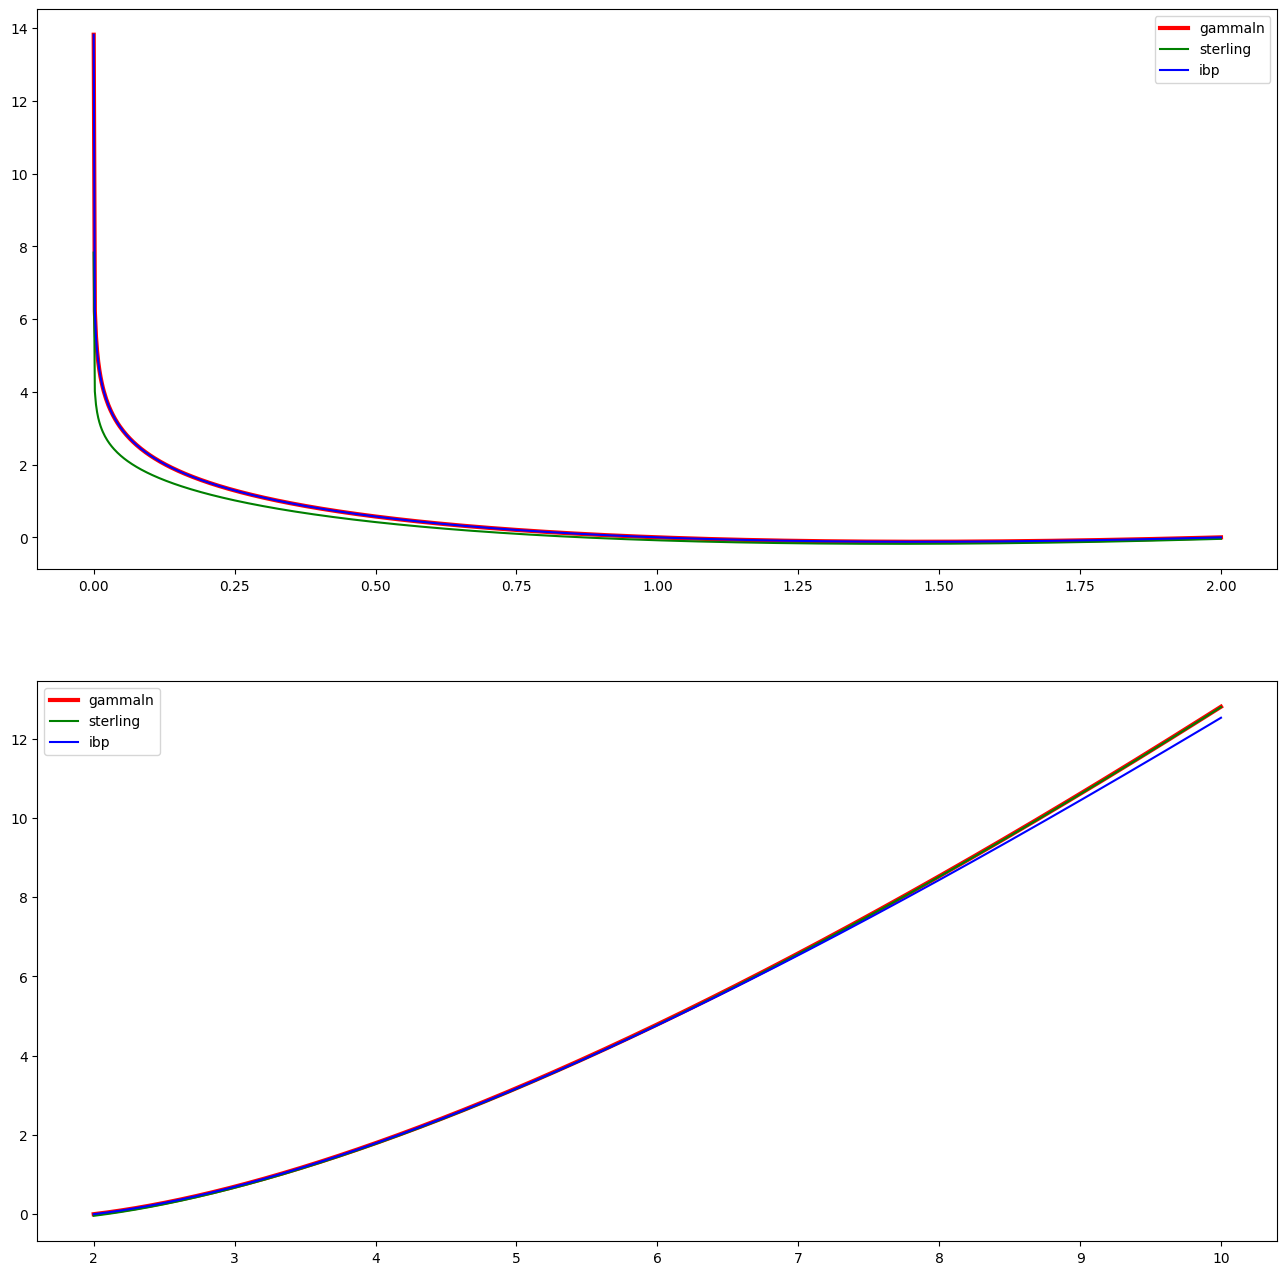

In [502]:
from matplotlib import pyplot as plt

# import seaborn as sns


fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 16))

x = np.linspace(1e-6, 2, 1000)
ax1.plot(x, [gammaln(i) for i in x], "-r", label="gammaln", linewidth=3)
ax1.plot(x, [gammaln_pos_float(i) for i in x], "-g", label="sterling")
ax1.plot(x, [gammaln_pos_float_2(i) for i in x], "-b", label="ibp")
ax1.legend()
x = np.linspace(2, 10, 1000)
ax2.plot(x, [gammaln(i) for i in x], "-r", label="gammaln", linewidth=3)
ax2.plot(x, [gammaln_pos_float(i) for i in x], "-g", label="sterling")
ax2.plot(x, [gammaln_pos_float_2(i) for i in x], "-b", label="ibp")
ax2.legend()

## Compute precision

The higher $x\geq 1$, the smaller the error given by $(x+1)e^{-x}$. Unfortunately, the more iterations $n$ are required and the more numerical instable (computes $x^n$) are required. 
Use the following cell to determine the error for $x$ and modify the number of iterations $n$ to see whether the sum has converged (the fraction becomes very small)

In [497]:
# Compute precision

z = 1.5
x = 12  # 20.0
N = 30  # 60

result = 0.0
for n in range(N):
    denominator = 1.0
    for i in range(n):
        denominator *= z + i
    nominator = x**n
    result += nominator / denominator

print(
    f"value of the sum: {result},\n"
    f"increment after {N} iterations (0 if converged): {nominator / denominator},\n"
    f"Max error: {(x + 1) * np.exp(-x)}"
)

value of the sum: 41637.56252829052,
increment after 30 iterations (0 if converged): 0.36350559941745314,
Max error: 7.987476059326673e-05


The final function could look like this

In [384]:
@njit()
def gammaln_pos_float_final(z: float64):
    """Logarithm of the Gamma function for positive integer values (as float64)."""

    if z > 20.0:
        # Has error
        f = np.log(np.sqrt(2 * np.pi))
        return f + np.log(z) * (z - 0.5) - z
    else:
        x = 15.0
        result = 0.0
        for n in range(30):
            denominator = 1.0
            for i in range(n + 1):
                denominator *= z + i
            result += x**n / denominator
        return np.log(x**z * np.exp(-x) * result)